In [128]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import random

In [129]:
d = 2

shapes = {
    (0, 0): (2, 2, d),
    (0, 1): (2, 2, 2, d),
    (0, 2): (2, 2, d),
    (1, 0): (2, 2, d),
    (1, 1): (2, d),
    (1, 2): (2, d),
    (2, 0): (2, 2, d),
    (2, 1): (2, 2, d),
    (2, 2): (2, d)}
nodes = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(3) for j in range(3)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(nodes[(0, 0)][0], nodes[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (2, 2), 1, 0)]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

def product_state(ttn, bond_dim=2):
    zero_state = deepcopy(ttn)
    zero = np.asarray([1/np.sqrt(2), 1/np.sqrt(2)])
    for node_id in zero_state.nodes.keys():
        n = zero_state.tensors[node_id].ndim - 1
        tensor = zero.reshape((1,) * n + (2,))
        T = np.pad(tensor, n*((bond_dim, bond_dim),) + ((0, 0),))
        zero_state.tensors[node_id] = T
        zero_state.nodes[node_id].link_tensor(T)  
    return zero_state


In [130]:
def get_neighbors_with_distance_HV(Lx, Ly, distance):
  current_sites = []  # List to store current sites
  neighbor_sites = []  # List to store neighbor sites

  for i in range(Lx):
      for j in range(Ly):
          current_site = (i, j)
          # Check possible neighbor offsets
          for di in range(-distance, distance + 1):
              for dj in range(-distance, distance + 1):
                  # Only consider neighbors that are exactly at the specified distance
                  if math.sqrt(di**2 + dj**2) == distance:
                      neighbor_site = (i + di, j + dj)
                      # Check if the neighbor is within bounds
                      if 0 <= neighbor_site[0] < Lx and 0 <= neighbor_site[1] < Ly:
                          # Ensure we only add each unique connection once
                          if current_site < neighbor_site:  
                              current_sites.append(current_site)
                              neighbor_sites.append(neighbor_site)

  return current_sites, neighbor_sites  # Return as a list with two elements

def get_neighbors_with_distance_HDV(Lx, Ly, distance):
  current_sites = []  # List to store current sites
  neighbor_sites = []  # List to store neighbor sites

  # Define the allowed distances
  if distance == 1:
      allowed_distances = [1, math.sqrt(2)]  # Both orthogonal and diagonal
  elif distance == 2:
      allowed_distances = [2, math.sqrt(8)]  # Both orthogonal and diagonal (2√2)
  else:
      allowed_distances = [distance]

  for i in range(Lx):
      for j in range(Ly):
          current_site = (i, j)
          # Check possible neighbor offsets
          for di in range(-distance, distance + 1):
              for dj in range(-distance, distance + 1):
                  # Calculate the exact Euclidean distance
                  exact_distance = math.sqrt(di**2 + dj**2)
                  
                  # Check if the distance matches any of the allowed distances
                  if any(abs(exact_distance - d) < 1e-10 for d in allowed_distances):
                      neighbor_site = (i + di, j + dj)
                      # Check if the neighbor is within bounds
                      if 0 <= neighbor_site[0] < Lx and 0 <= neighbor_site[1] < Ly:
                          # Ensure we only add each unique connection once
                          if current_site < neighbor_site:
                              current_sites.append(current_site)
                              neighbor_sites.append(neighbor_site)

  return current_sites, neighbor_sites


def get_checkerboard_pattern(Lx, Ly):
    black_sites = []
    white_sites = []

    for x in range(Lx):
        for y in range(Ly):
            current_site = f"({x},{y})"
            if (x + y) % 2 == 0:
                black_sites.append(current_site)
            else:
                white_sites.append(current_site)

    # Output the sites in each category
    return black_sites, white_sites


def get_random_half_sites(Lx, Ly): 
    total_sites = Lx * Ly

    # Generate a list of all sites
    all_sites = [f"({x},{y})" for x in range(Lx) for y in range(Ly)]

    # Shuffle and split into two halves
    random.shuffle(all_sites)
    half = total_sites // 2

    black_sites = all_sites[:half]
    white_sites = all_sites[half:]

    return black_sites, white_sites


def uniform_product_state(ttn,
                          local_state, 
                          bond_dim = 2): 
    product_state = deepcopy(ttn)
    for node_id in product_state.nodes.keys():
        n = product_state.tensors[node_id].ndim - 1
        tensor = local_state.reshape((1,) * n + (2,))
        T = np.pad(tensor, n*((bond_dim, bond_dim),) + ((0, 0),))
        product_state.tensors[node_id] = T
        product_state.nodes[node_id].link_tensor(T)  
    return product_state
    
def alternating_product_state(ttn, 
                              black_state,
                              white_state,
                              bond_dim = 2, 
                              pattern = "checkerboard"): 
    Lx = len(ttn.nodes.keys()) // 3 
    Ly = Lx
    product_state = deepcopy(ttn)
    if pattern == "checkerboard":
       black_sites , white_sites = get_checkerboard_pattern(Lx,Ly)
    elif pattern == "half_random":
       black_sites , white_sites = get_random_half_sites(Lx,Ly)
    for node in black_sites:
        black_id = "Site" + f"{node}"
        n = product_state.tensors[black_id].ndim - 1
        tensor = black_state.reshape((1,) * n + (2,))
        T = np.pad(tensor, n*((bond_dim, bond_dim),) + ((0, 0),))
        product_state.tensors[black_id] = T
        product_state.nodes[black_id].link_tensor(T)  
    for node in white_sites:
        white_id = "Site" + f"{node}"
        n = product_state.tensors[white_id].ndim - 1
        tensor = white_state.reshape((1,) * n + (2,))
        T = np.pad(tensor, n*((bond_dim, bond_dim),) + ((0, 0),))
        product_state.tensors[white_id] = T
        product_state.nodes[white_id].link_tensor(T)  

    return product_state

local_state = np.array([0,1])
ttn = uniform_product_state(ttn ,local_state, bond_dim= 2)

black_state = np.array([0,1])
white_state = np.array([1,0])
ttn = alternating_product_state(ttn, black_state, white_state, bond_dim = 0,  pattern = "checkerboard")

In [131]:
#ttn.canonical_form("Site(2,2)" , ptn.SplitMode.FULL)
#ttn.canonical_form("Site(0,0)" , ptn.SplitMode.REDUCED)
#ttn.canonical_form("Site(2,2)" , ptn.SplitMode.REDUCED)

In [132]:
def BoseHubbard_ham(t, U, m, Lx, Ly , d):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dimension=d)
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        "n": number_op,
        f"I{d}": np.eye(d)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(d)),
        "m*n": - m * number_op,
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
            terms.append(ptn.TensorProduct({current_site: "m*n"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)

def Number_op_total(Lx, Ly, dim=2):
    number_op = ptn.bosonic_operators(dim)[2]
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}

    terms = []
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "n"}))
    return ptn.Hamiltonian(terms, conversion_dict)
 
def Number_op_local(node_id, dim=2):
    number_op = ptn.bosonic_operators(dim)[2]
    conversion_dict = {"n": number_op , f"I{dim}": np.eye(dim)}
    term = ptn.TensorProduct({node_id: "n"})
    return ptn.Hamiltonian(term, conversion_dict)       


def Correlation_function(node_id1, node_id2, dim=2):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        f"I{dim}": np.eye(dim)
    }
    
    terms = []
    terms.append(ptn.TensorProduct({node_id1: "b^dagger", node_id2: "b"}))
    return ptn.Hamiltonian(terms, conversion_dict)

def Random_op(Lx, Ly, dim , seed = 0):
    np.random.seed(seed)
    possible_operators = [ptn.crandn((dim,dim)) for _ in range(len(ttn.nodes.keys()))] 
    conversion_dict = {f"I{dim}": np.eye(dim)}
    for i, node_id in enumerate(ttn.nodes.keys()):
        conversion_dict[node_id] = possible_operators[i]    

    terms = [ptn.TensorProduct({f"Site({x},{y})": f"Site({x},{y})" 
                                for x in range(Lx) for y in range(Ly)})]
    return ptn.Hamiltonian(terms, conversion_dict)   


In [133]:
def spatial_correlation_function(Lx, Ly, dist, dim, mode = "HV"):
    if mode == "HV":
        current_sites, neighbor_sites = get_neighbors_with_distance_HV(Lx, Ly, dist)
    elif mode == "HDV":
        current_sites, neighbor_sites = get_neighbors_with_distance_HDV(Lx, Ly, dist)

    # Define operators
    creation_op, annihilation_op, number_op = ptn.bosonic_operators(dim)
    conversion_dict = {
        "b^dagger": creation_op / len(current_sites),
        "b": annihilation_op,
        f"I{dim}": np.eye(dim)
    }

    # Step 3: Create correlation terms for each pair
    terms = []
    for site1, site2 in zip(current_sites, neighbor_sites):
        node_id1 = f"Site({site1[0]},{site1[1]})"
        node_id2 = f"Site({site2[0]},{site2[1]})"
        # Add b^†_i b_j term
        terms.append(ptn.TensorProduct({node_id1: "b^dagger", node_id2: "b"}))


    return ptn.Hamiltonian(terms, conversion_dict)

In [134]:
t = 3
u = 2
m = 1
Lx = 3
Ly = 3

H1 = BoseHubbard_ham(t, u, m, Lx, Ly, d)
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

I = ptn.TTNO.Identity(ttn)

Corr = Correlation_function("Site(0,0)", "Site(2,2)", d)
Corr = Corr.pad_with_identities(ttn, symbolic= True)
Corr = ptn.TTNO.from_hamiltonian(Corr, ttn)

spatial_corr_dist_1 = spatial_correlation_function(Lx, Ly, 1, d)
spatial_corr_dist_1 = spatial_corr_dist_1.pad_with_identities(ttn, symbolic= True)
spatial_corr_dist_1 = ptn.TTNO.from_hamiltonian(spatial_corr_dist_1, ttn)

spatial_corr_dist_2 = spatial_correlation_function(Lx, Ly, 2, d)
spatial_corr_dist_2 = spatial_corr_dist_2.pad_with_identities(ttn, symbolic= True)
spatial_corr_dist_2 = ptn.TTNO.from_hamiltonian(spatial_corr_dist_2, ttn)

node_id_list = list(ttn.nodes.keys())
N_local_list = []
for node_id in node_id_list:
    N_local = Number_op_local(node_id, d)
    N_local = N_local.pad_with_identities(ttn, symbolic= True)
    N_local = ptn.TTNO.from_hamiltonian(N_local, ttn)
    N_local_list.append(N_local)

N = Number_op_total(Lx, Ly, d)
N = N.pad_with_identities(ttn, symbolic= True)
N = ptn.TTNO.from_hamiltonian(N, ttn)    

random_op = Random_op(Lx= Lx,
                      Ly= Ly,
                      dim = d,
                      seed= 10)
random_op = random_op.pad_with_identities(ttn, symbolic= False)
Rand = ptn.TTNO.from_hamiltonian(random_op, ttn)

In [135]:
L = Lx * Ly

# state_vector
state_vector , state_order = ttn.completely_contract_tree(to_copy= True)
print("State vector shape: ", state_vector.shape)
print("State order: ", state_order)
state_vector = state_vector.reshape((d**L))

# BH hamiltonian matrix
BH_exact = BoseHubbard_ham(t, u, m, Lx, Ly, d)
BH_exact = BH_exact.pad_with_identities(ttn , symbolic= True)
BH_exact = BH_exact.to_tensor(ttn)
print("ham_order", BH_exact.node_identifiers)
BH_exact = BH_exact.operator
print( "L_tn.shape" , BH_exact.shape) 
BH_exact = BH_exact.reshape((d**L , d**L))
BH_exact = BH_exact.T

# Correlation function matrix
Corr_exact = Correlation_function("Site(0,0)", "Site(2,2)", d)
Corr_exact = Corr_exact.pad_with_identities(ttn, symbolic= True)
Corr_exact = Corr_exact.to_tensor(ttn)
print("op_order" , Corr_exact.node_identifiers)
Corr_exact = Corr_exact.operator
print("op.shape" , Corr_exact.shape) 
Corr_exact= Corr_exact.reshape((d**L, d**L))
Corr_exact = Corr_exact.T


State vector shape:  (2, 2, 2, 2, 2, 2, 2, 2, 2)
State order:  ['Site(0,0)', 'Site(0,1)', 'Site(1,1)', 'Site(0,2)', 'Site(1,2)', 'Site(1,0)', 'Site(2,0)', 'Site(2,1)', 'Site(2,2)']
ham_order ['Site(0,0)', 'Site(0,1)', 'Site(1,1)', 'Site(0,2)', 'Site(1,2)', 'Site(1,0)', 'Site(2,0)', 'Site(2,1)', 'Site(2,2)']
L_tn.shape (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
op_order ['Site(0,0)', 'Site(0,1)', 'Site(1,1)', 'Site(0,2)', 'Site(1,2)', 'Site(1,0)', 'Site(2,0)', 'Site(2,1)', 'Site(2,2)']
op.shape (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)


In [136]:
exact = ptn.ExactTimeEvolution(initial_state = state_vector, 
                               hamiltonian = BH_exact, 
                               time_step_size = 0.001,
                               final_time= 1,
                               operators= Corr_exact)

tdvp = ptn.FirstOrderOneSiteTDVP(initial_state = ttn,
                                 hamiltonian = ttno,
                                 time_step_size = 0.001,
                                 final_time = 1,
                                 operators = [Corr , I],
                                 num_vecs = 3, 
                                 tau = 1e-2,
                                 SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= -np.inf , total_tol = -np.inf),
                                 expansion_steps = 100,
                                 initial_tol = 1e-30,
                                 tol_step = 1e5,
                                 rel_ttn_tot_bond = np.inf,
                                 max_ttn_bond = 54)

In [137]:
stop

NameError: name 'stop' is not defined

In [ ]:
exact.run(evaluation_time=2)

In [ ]:
tdvp.run_ex(evaluation_time=2)
times = tdvp.times()


In [ ]:
tdvp.operator_results()[1]

In [ ]:
tdvp_pad = tdvp.operator_results()[0]

In [ ]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(5, 5))

# First plot
axs1.plot(times , exact.operator_results()[0], label='exact')
axs1.plot(times , tdvp.operator_results()[0], label='tdvp')
axs1.plot(times , tdvp_pad, label='tdvp_pad , 1.11s')
axs1.set_xlabel("Time $t$")
axs1.set_ylabel("<O>")
axs1.set_title("TDVP vs exact")

# Add a legend to distinguish between the two plots
axs1.legend()

plt.show()

In [140]:
import qutip as qt

def create_bose_hubbard_2d(Lx, Ly, n_bosons, J, U, mu):
    """
    Create 2D Bose-Hubbard Hamiltonian with chemical potential
    
    Parameters:
    -----------
    Lx, Ly: int
        Lattice dimensions
    n_bosons: int
        Maximum number of bosons per site
    J: float
        Hopping strength
    U: float
        On-site interaction strength
    mu: float
        Chemical potential
    """
    n_sites = Lx * Ly
    
    # Create destruction operators for each site
    a_ops = []
    for i in range(n_sites):
        op_list = [qt.qeye(n_bosons) for j in range(n_sites)]
        op_list[i] = qt.destroy(n_bosons)
        a_ops.append(qt.tensor(op_list))
    
    # Create Hamiltonian
    H = 0
    
    # Helper function to get site index from 2D coordinates
    def get_index(x, y):
        return x * Ly + y
    
    # Hopping terms in x-direction
    for x in range(Lx):
        for y in range(Ly):
            # x-direction hopping
            if x < Lx - 1:
                i = get_index(x, y)
                j = get_index(x + 1, y)
                H += -J * (a_ops[i].dag() * a_ops[j] + a_ops[j].dag() * a_ops[i])
            
            # y-direction hopping
            if y < Ly - 1:
                i = get_index(x, y)
                j = get_index(x, y + 1)
                H += -J * (a_ops[i].dag() * a_ops[j] + a_ops[j].dag() * a_ops[i])
    
    # On-site interaction and chemical potential terms
    for i in range(n_sites):
        n_op = a_ops[i].dag() * a_ops[i]
        H += (U/2) * n_op * (n_op - 1)  # Interaction
        H += -mu * n_op                  # Chemical potential
    
    return H, a_ops


class BoseHubbard2D:
  def __init__(self, Lx, Ly, n_bosons, J, U, mu):
      self.Lx = Lx
      self.Ly = Ly
      self.n_bosons = n_bosons
      self.J = J
      self.U = U
      self.mu = mu
      
      self.H, self.a_ops = create_bose_hubbard_2d(Lx, Ly, n_bosons, J, U, mu)
      self.n_ops = [a.dag() * a for a in self.a_ops]

  def uniform_product_state(self, local_state) :
      # Create the single-site state in QuTiP format
      single_site = qt.Qobj(local_state)

      # Create the product state
      state = single_site
      for _ in range(self.Lx * self.Ly - 1):
          state = qt.tensor(state, single_site)
      return state
    
  def get_checkerboard_pattern(self):
        black_sites = []
        white_sites = []
        for x in range(self.Lx):
            for y in range(self.Ly):
                if (x + y) % 2 == 0:
                    black_sites.append((x, y))  # Append as a tuple
                else:
                    white_sites.append((x, y))  # Append as a tuple
        return black_sites, white_sites

  def get_random_half_sites(self):
        total_sites = self.Lx * self.Ly

        # Generate a list of all sites as tuples instead of strings
        all_sites = [(x, y) for x in range(Lx) for y in range(Ly)]

        # Shuffle and split into two halves
        random.shuffle(all_sites)
        half = total_sites // 2

        black_sites = all_sites[:half]
        white_sites = all_sites[half:]

        return black_sites, white_sites

  def alternating_product_state(self, black_state, white_state, pattern):
        # Create single-site states in QuTiP format
        black_site_qobj = qt.Qobj(black_state)
        white_site_qobj = qt.Qobj(white_state)
        
        # Initialize an empty list for product state components
        product_state_components = []
        
        # Choose the pattern and get black/white site lists
        if pattern == "checkerboard":
            black_sites, white_sites = self.get_checkerboard_pattern()
        elif pattern == "half_random":
            black_sites, white_sites = self.get_random_half_sites()
        else:
            raise ValueError("Invalid pattern. Use 'checkerboard' or 'half_random'.")

        # Initialize the state list with white states as placeholders
        for x in range(self.Lx):
            for y in range(self.Ly):
                product_state_components.append(white_site_qobj)
        
        # Assign black and white states to the specific indices
        for site in black_sites:
            idx = site[0] * self.Ly + site[1]
            product_state_components[idx] = black_site_qobj

        # Tensor product to create the full product state
        product_state = product_state_components[0]
        for state in product_state_components[1:]:
            product_state = qt.tensor(product_state, state)
      
        return product_state



  def evolve_system(self, psi0, end_time, dt=0.1):
      """[Previous implementation remains the same]"""
      times = np.linspace(0, end_time, int(end_time/dt) + 1)
      self.result = qt.sesolve(self.H, psi0, times)
      return self.result
  
  def calculate_occupation(self, state):
      """
      Calculate occupation number for each site
      
      Parameters:
      -----------
      state: qutip.Qobj
          Quantum state at a specific time
          
      Returns:
      --------
      numpy.ndarray
          2D array of shape (Lx, Ly) containing occupation numbers
      """
      occupations = np.zeros((self.Lx, self.Ly))
      
      for i in range(self.Lx):
          for j in range(self.Ly):
              idx = i * self.Ly + j
              occupations[i, j] = qt.expect(self.n_ops[idx], state)

      return occupations

  def calculate_spatial_correlation_function(self, state, distance, mode = "HV" , Normalize = False):
    """
    Calculate first-order correlation function: g₁(r1,r2) = ⟨a†(r1)a(r2)⟩/√(⟨n(r1)⟩⟨n(r2)⟩)
    """
    if mode == "HV":
       current_sites, neighbor_sites = get_neighbors_with_distance_HV(self.Lx, self.Ly, distance)
    elif mode == "HDV":
       current_sites, neighbor_sites = get_neighbors_with_distance_HDV(self.Lx, self.Ly, distance)   

    result = 0
    if Normalize:
        # Scales with density (Larger values in high-density regions)
        # gives actual coherence magnitude
        # Studying transport properties
        for site1, site2 in zip(current_sites, neighbor_sites):
            # Convert 2D coordinates to 1D index
            idx1 = site1[0] * self.Ly + site1[1]
            idx2 = site2[0] * self.Ly + site2[1]
        
            n1 = qt.expect(self.n_ops[idx1], state)
            n2 = qt.expect(self.n_ops[idx2], state)
            corr = qt.expect(self.a_ops[idx1].dag() * self.a_ops[idx2], state)
            result += corr / np.sqrt(n1 * n2)
    else:
        # Independent of density (Same value for same "degree of coherence")
        # Studying phase transitions / universal behavior
        for site1, site2 in zip(current_sites, neighbor_sites):
            # Convert 2D coordinates to 1D index
            idx1 = site1[0] * self.Ly + site1[1]
            idx2 = site2[0] * self.Ly + site2[1]

            corr = qt.expect(self.a_ops[idx1].dag() * self.a_ops[idx2], state)
            result += corr       

    return result / len(current_sites)

  def calculate_density_density_correlation(self, state, distance, mode = "HV" , Normalize = False):
    """
    Calculate density-density correlation: g₂(r1,r2) = ⟨n(r1)n(r2)⟩/(⟨n(r1)⟩⟨n(r2)⟩)
    """

    if mode == "HV":
       current_sites, neighbor_sites = get_neighbors_with_distance_HV(self.Lx, self.Ly, distance)
    elif mode == "HDV":
       current_sites, neighbor_sites = get_neighbors_with_distance_HDV(self.Lx, self.Ly, distance)   

    result = 0
    # Mott insulator : both negative
    # Superfluid : both positive
    if Normalize:
        # Measures genuine correlations beyond mean-field
        # Goes to zero for uncorrelated states
        # Can be positive (attraction) or negative (repulsion)
        for site1, site2 in zip(current_sites, neighbor_sites):
            # Convert 2D coordinates to 1D index
            idx1 = site1[0] * self.Ly + site1[1]
            idx2 = site2[0] * self.Ly + site2[1]
        
            n1 = qt.expect(self.n_ops[idx1], state)
            n2 = qt.expect(self.n_ops[idx2], state)
            n1n2 = qt.expect(self.n_ops[idx1] * self.n_ops[idx2], state)
            result += (n1n2 - np.sqrt(n1 * n2)) / np.sqrt(n1 * n2)
    else:
        # g^(2) = 0: uncorrelated (Poissonian)
        # g^(2) > 0: super-Poissonian (bunching)
        # g^(2) < 0: sub-Poissonian (antibunching)
        for site1, site2 in zip(current_sites, neighbor_sites):
            # Convert 2D coordinates to 1D index
            idx1 = site1[0] * self.Ly + site1[1]
            idx2 = site2[0] * self.Ly + site2[1]
        
            n1 = qt.expect(self.n_ops[idx1], state)
            n2 = qt.expect(self.n_ops[idx2], state)
            n1n2 = qt.expect(self.n_ops[idx1] * self.n_ops[idx2], state)
            result += n1n2 - np.sqrt(n1 * n2)       

    return result / len(current_sites)

  def occupation_results(self, evaluation_time, results):
    """
    Calculate occupation numbers at regular step intervals
    
    Parameters:
    -----------
    evaluation_time: int
        Calculate results every nth step
    results: qutip.Result
        Results from time evolution
        
    Returns:
    --------
    tuple: (numpy.ndarray, numpy.ndarray)
        - occupations: array of shape (n_evaluations, Lx, Ly)
        - eval_times: array of corresponding times
    """
    times = np.array(results.times)
    states = results.states
    
    # Get indices at evaluation_time intervals (0, evaluation_time, 2*evaluation_time, ...)
    evaluation_indices = np.arange(0, len(states), evaluation_time).astype(int)
    
    # Ensure we do not exceed the number of states
    evaluation_indices = evaluation_indices[evaluation_indices < len(states)]
    
    occupations = np.zeros((len(evaluation_indices), self.Lx, self.Ly))
    eval_times = times[evaluation_indices]
    
    for i, idx in enumerate(evaluation_indices):
        occupations[i] = self.calculate_occupation(states[idx])
            
    return occupations, eval_times

  def spatial_correlation_function_results(self, evaluation_time, results, 
                                        distance, mode="HV", Normalize=False):
    """
    Calculate spatial correlations at regular step intervals
    """
    times = np.array(results.times)
    states = results.states
    
    # Get indices at evaluation_time intervals
    evaluation_indices = np.arange(0, len(states), evaluation_time).astype(int)
    
    # Ensure we do not exceed the number of states
    evaluation_indices = evaluation_indices[evaluation_indices < len(states)]
    
    correlations = np.zeros(len(evaluation_indices), dtype=complex)
    eval_times = times[evaluation_indices]
    
    for i, idx in enumerate(evaluation_indices):
        correlations[i] = self.calculate_spatial_correlation_function(
            states[idx], distance, mode, Normalize)
            
    return correlations, eval_times

  def density_density_correlation_results(self, evaluation_time, results, 
                                    distance, mode="HV", Normalize=False):
    """
    Calculate density-density correlations at regular step intervals
    """
    times = np.array(results.times)
    states = results.states
    
    # Get indices at evaluation_time intervals
    evaluation_indices = np.arange(0, len(states), evaluation_time).astype(int)
    
    # Ensure we do not exceed the number of states
    evaluation_indices = evaluation_indices[evaluation_indices < len(states)]
    
    correlations = np.zeros(len(evaluation_indices), dtype=complex)
    eval_times = times[evaluation_indices]
    
    for i, idx in enumerate(evaluation_indices):
        correlations[i] = self.calculate_density_density_correlation(
            states[idx], distance, mode, Normalize)
            
    return correlations, eval_times

In [141]:
# Example usage:
# System initialization
Lx = 4
Ly = 4
n_bosons = 2
J = 0.1
U = 4
mu = 5
system = BoseHubbard2D(Lx, Ly, n_bosons, J, U, mu)

# Create initial state
initial_state = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
psi0 = system.uniform_product_state(initial_state)

black_state = np.array([0,1])
white_state = np.array([1,0])
psi0 = system.alternating_product_state(black_state, white_state, pattern= "checkerboard")

# Evolve system
end_time = 20
dt = 0.1
result = system.evolve_system(psi0, end_time=end_time, dt=dt)


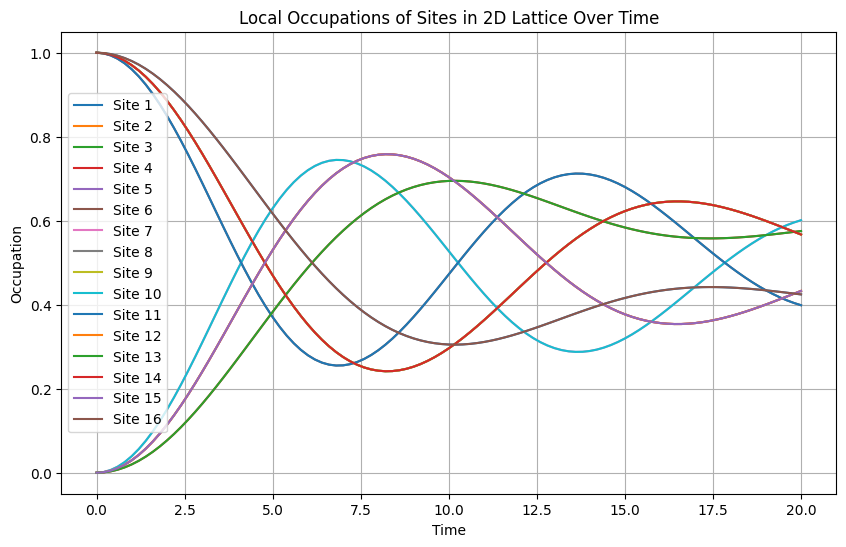

In [ ]:
eval_time = 2
occupations, occ_times = system.occupation_results(eval_time, result)


time_steps = occupations.shape[0]
time = np.arange(time_steps)
occupations_flat = occupations.reshape(time_steps, -1)

# Plot all occupations in the same plot
plt.figure(figsize=(10, 6))
for i in range(occupations_flat.shape[1]):
    plt.plot(corr_times, occupations_flat[:, i], label=f'Site {i + 1}')

plt.xlabel('Time')
plt.ylabel('Occupation')
plt.title('Local Occupations of Sites in 2D Lattice Over Time')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Text(0.5, 0.98, 'Evolution of Local Occupation Over Time (Heatmap)')

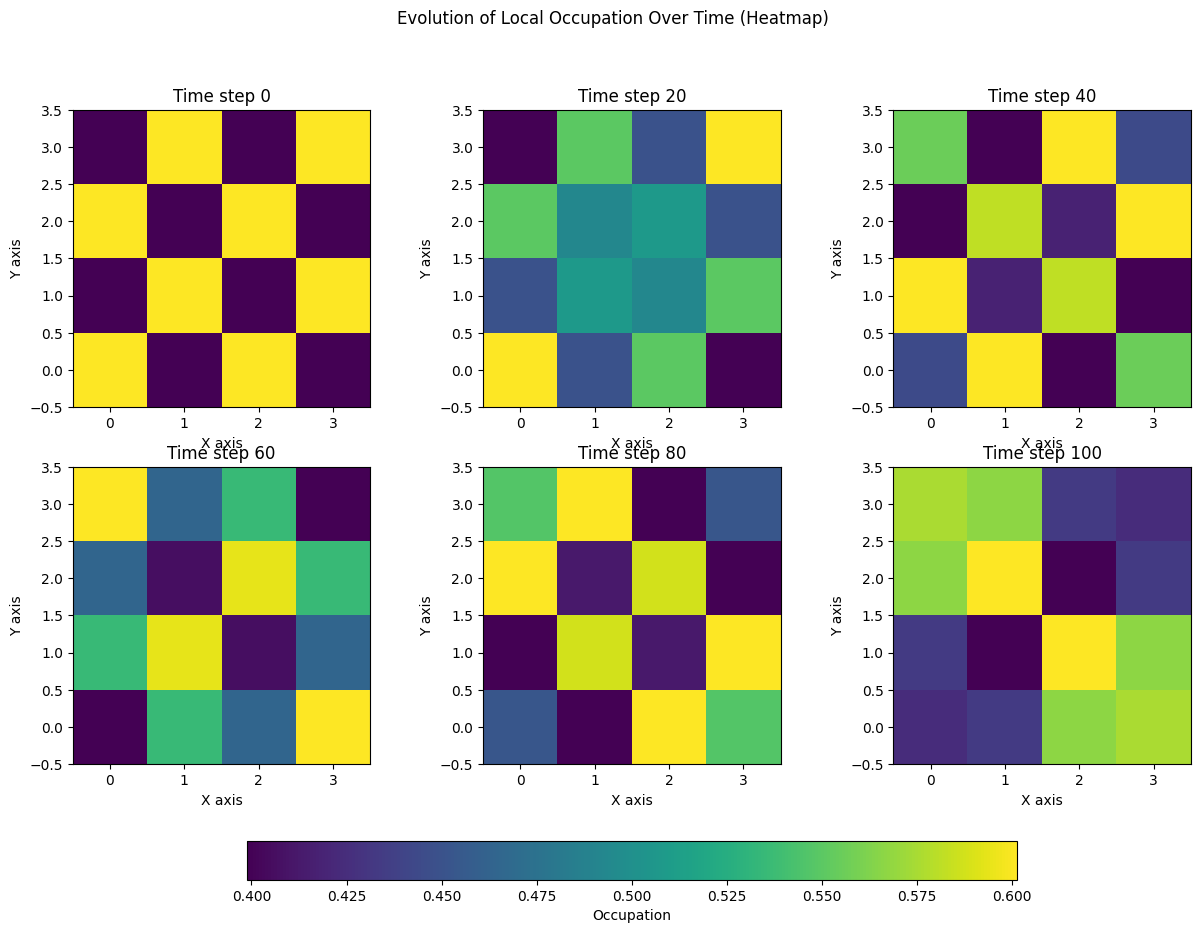

In [142]:
# Select time indices for 6 evenly spaced time steps
time_indices = np.linspace(0, time_steps - 1, 6, dtype=int)

# Plot heatmaps for selected time steps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, time_index in zip(axes.flat, time_indices):
    # Plot heatmap of the lattice occupation at the selected time step
    im = ax.imshow(occupations[time_index], cmap='viridis', origin='lower')
    ax.set_title(f"Time step {time_index}")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")

# Add a color bar to indicate the occupation scale
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Occupation")

plt.suptitle("Evolution of Local Occupation Over Time (Heatmap)")


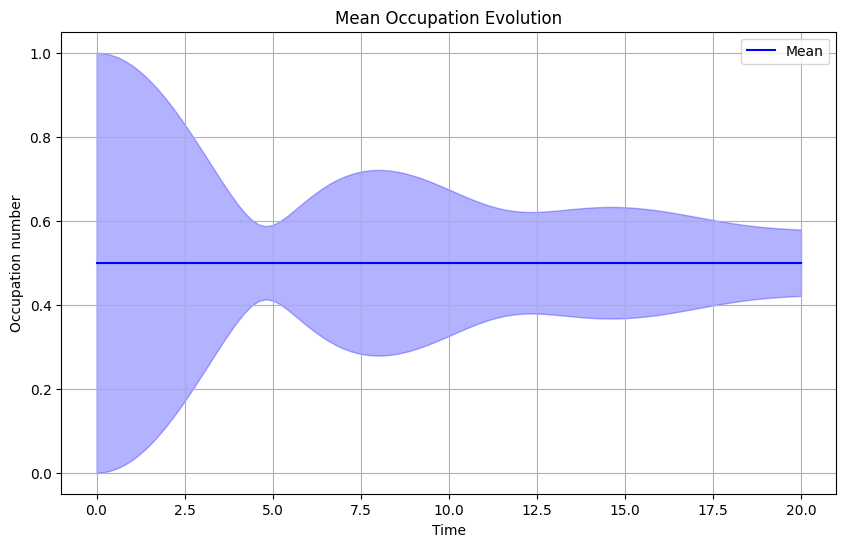

In [145]:
fig, ax1 = plt.subplots(figsize=(10, 6))

mean_occupation = np.mean(occupations, axis=(1,2))
std_occupation = np.std(occupations, axis=(1,2))
ax1.plot(occ_times, mean_occupation, 'b-', label='Mean')
ax1.fill_between(occ_times, 
             mean_occupation - std_occupation,
             mean_occupation + std_occupation,
             alpha=0.3, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Occupation number')
ax1.set_title('Mean Occupation Evolution')
ax1.grid(True)
ax1.legend()

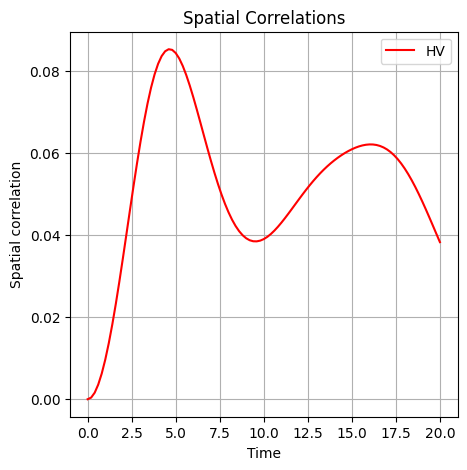

In [147]:
eval_time = 2
correlations_hv, corr_times = system.spatial_correlation_function_results(
  eval_time, result, distance=2, mode="HV" , Normalize= False)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.plot(corr_times, correlations_hv, 'r-', label='HV')
ax1.set_xlabel('Time')
ax1.set_ylabel('Spatial correlation')
ax1.set_title('Spatial Correlations')
ax1.grid(True)
ax1.legend()

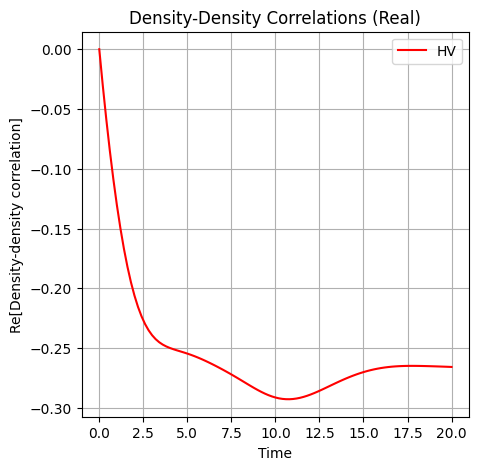

In [150]:
density_corr_hv, corr_times = system.density_density_correlation_results(
  eval_time, result, distance=3, mode="HV", Normalize= False)

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.plot(corr_times, density_corr_hv, 'r-', label='HV')
ax1.set_xlabel('Time')
ax1.set_ylabel('Re[Density-density correlation]')
ax1.set_title('Density-Density Correlations (Real)')
ax1.grid(True)
ax1.legend()

Available styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


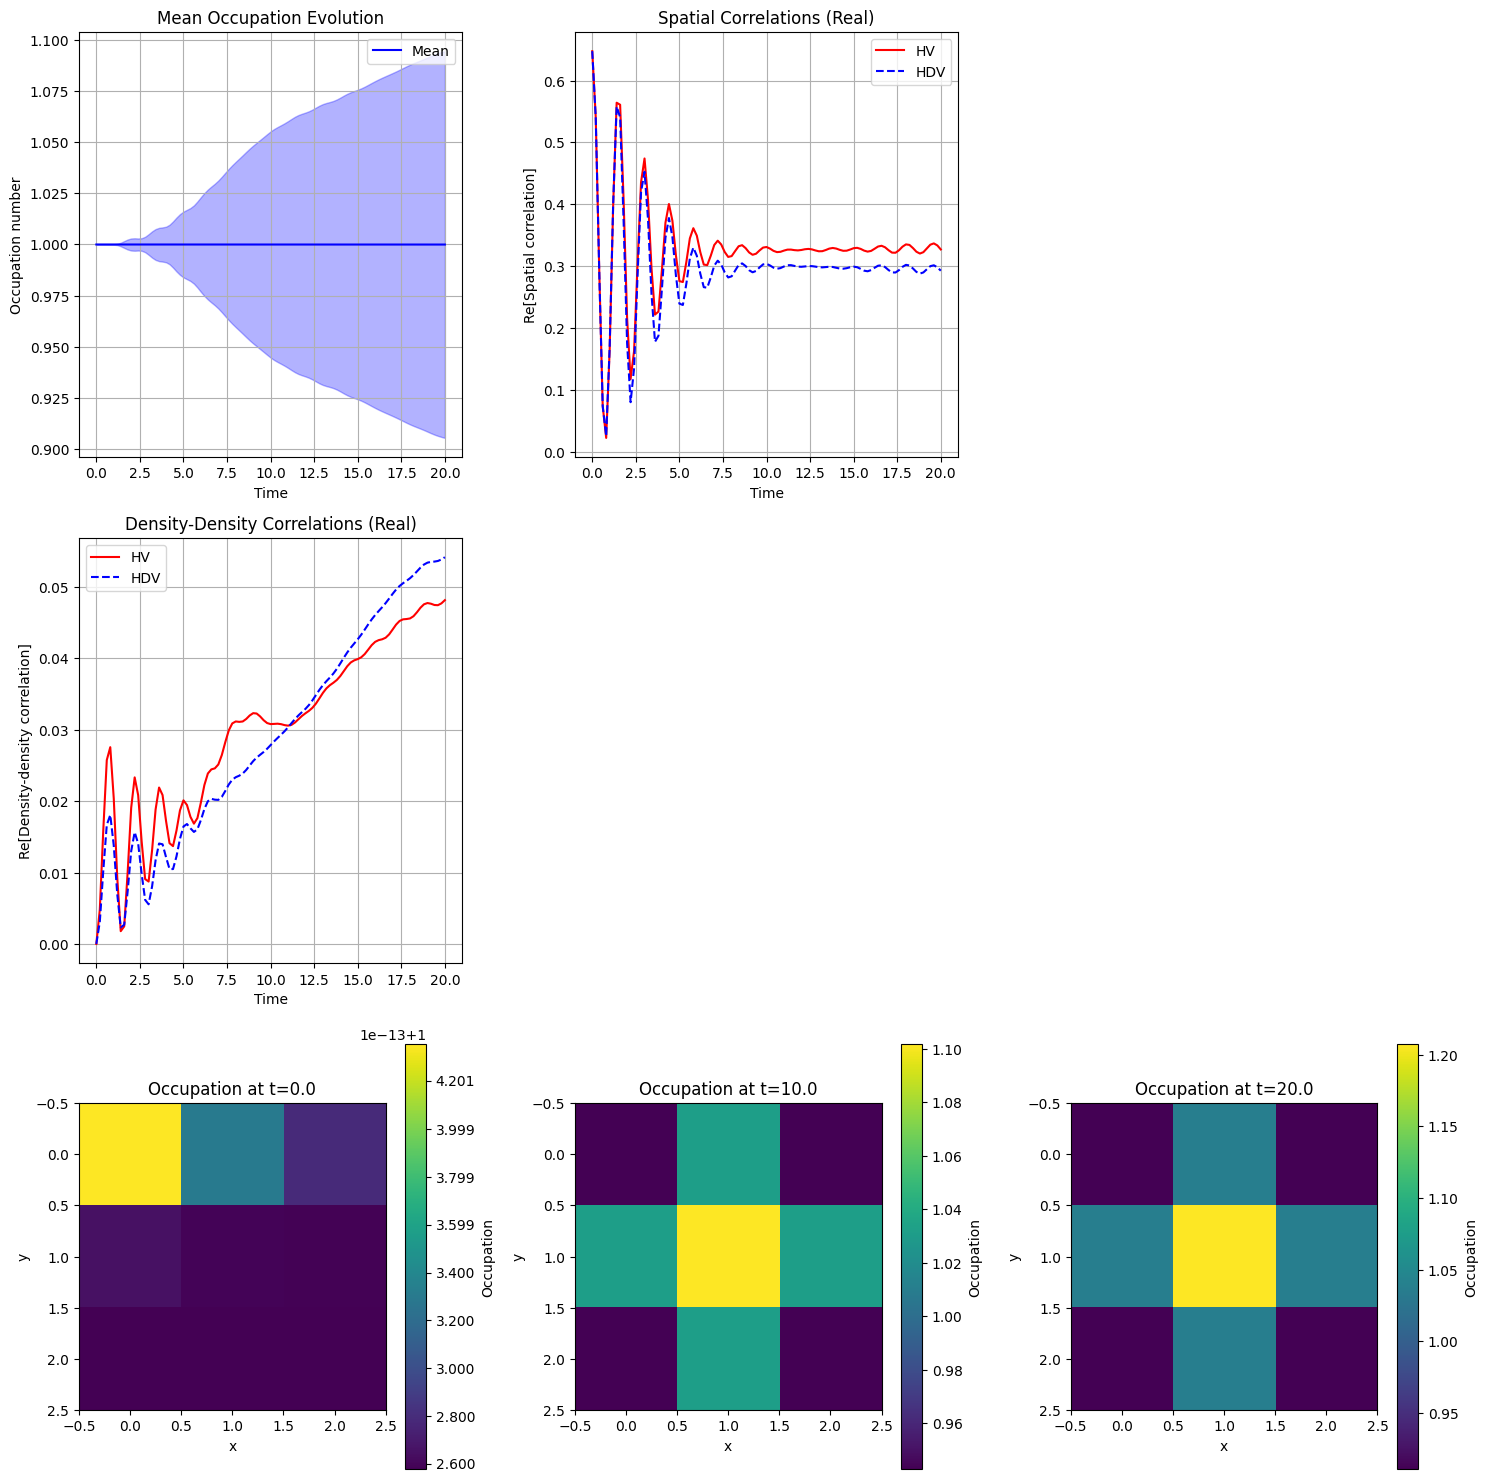

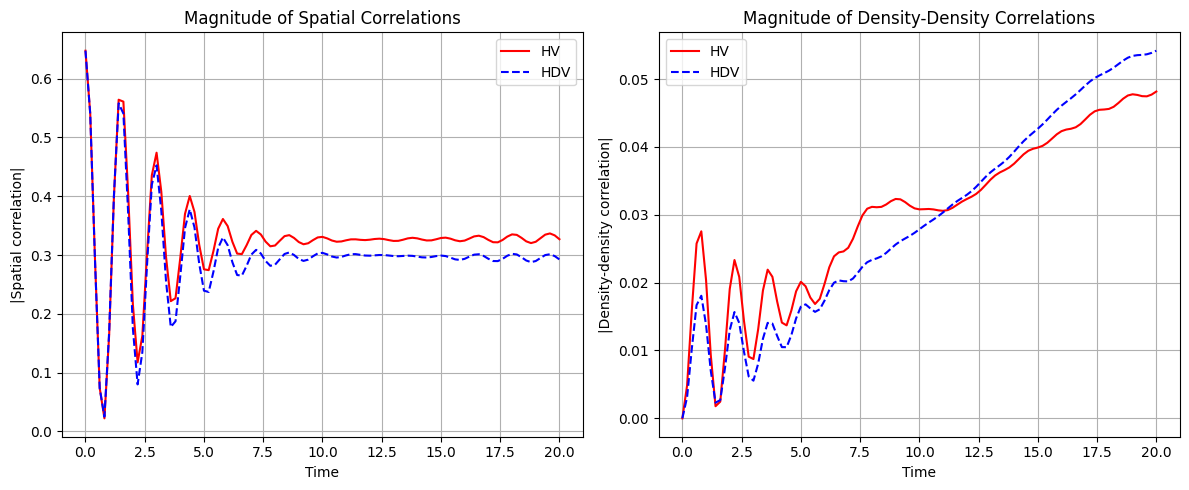

In [ ]:
import matplotlib.pyplot as plt

# First, let's check available styles and use a suitable one
print("Available styles:", plt.style.available)
plt.style.use('default')  # or try 'classic', 'bmh', 'ggplot'

# Create plots
fig = plt.figure(figsize=(15, 15))

# 1. Occupation number evolution
ax1 = plt.subplot(331)
mean_occupation = np.mean(occupations, axis=(1,2))
std_occupation = np.std(occupations, axis=(1,2))
ax1.plot(occ_times, mean_occupation, 'b-', label='Mean')
ax1.fill_between(occ_times, 
             mean_occupation - std_occupation,
             mean_occupation + std_occupation,
             alpha=0.3, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Occupation number')
ax1.set_title('Mean Occupation Evolution')
ax1.grid(True)
ax1.legend()

# 2. Spatial correlations (Real part)
ax2 = plt.subplot(332)
ax2.plot(corr_times, correlations_hv.real, 'r-', label='HV')
ax2.plot(corr_times, correlations_hdv.real, 'b--', label='HDV')
ax2.set_xlabel('Time')
ax2.set_ylabel('Re[Spatial correlation]')
ax2.set_title('Spatial Correlations (Real)')
ax2.grid(True)
ax2.legend()


# 4. Density-density correlations (Real part)
ax4 = plt.subplot(334)
ax4.plot(corr_times, density_corr_hv.real, 'r-', label='HV')
ax4.plot(corr_times, density_corr_hdv.real, 'b--', label='HDV')
ax4.set_xlabel('Time')
ax4.set_ylabel('Re[Density-density correlation]')
ax4.set_title('Density-Density Correlations (Real)')
ax4.grid(True)
ax4.legend()


# Additional plot: Magnitudes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Magnitude of spatial correlations
ax1.plot(corr_times, np.abs(correlations_hv), 'r-', label='HV')
ax1.plot(corr_times, np.abs(correlations_hdv), 'b--', label='HDV')
ax1.set_xlabel('Time')
ax1.set_ylabel('|Spatial correlation|')
ax1.set_title('Magnitude of Spatial Correlations')
ax1.grid(True)
ax1.legend()

# Magnitude of density-density correlations
ax2.plot(corr_times, np.abs(density_corr_hv), 'r-', label='HV')
ax2.plot(corr_times, np.abs(density_corr_hdv), 'b--', label='HDV')
ax2.set_xlabel('Time')
ax2.set_ylabel('|Density-density correlation|')
ax2.set_title('Magnitude of Density-Density Correlations')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Optional: Save plots
fig.savefig('bose_hubbard_analysis.png', dpi=300, bbox_inches='tight')